# Support Vector Classifiers and Support Vector Machines
__MATH 3480__ - Dr. Michael Olson

Reading:
* Geron, Chapter 5

![Machine Learning Landscape](./Images/3480_ML_Landscape.png)

## Support Vector Classifiers

### The Concept behind Support Vector Classifiers
* Two datasets have a gap between them
* Draw a line to separate the datasets
  * The distance from the closest datapoint to the separator is known as the __margin__
  * When the separator is in the middle, the margin is maximized for both datasets. This is known as the __maximal margin classifier__ (mmc)
  * This margin has two problems:
    1. Only works if data is linearly separable
    2. Sensitive to outliers - If you have a datapoint from one dataset that is near the other dataset, the mmc is decreased and misplaced. New datapoints near the second dataset could be classified in the first dataset
* Bias/Variance tradeoff
  * If we force all points to be correct, we have *low bias*. However, this overfits the data, so our predictions will often be incorrect, giving us a *high variance*
  * If we allow misclassifications, we have *high bias*, but the predictions are more accurate, giving us a *low variance*
* Allow misclassifications (or *margin violations*)
  * When we allow misclassifications, then we call that margin a __soft margin__
* Determine best soft margin
  * Use cross validation
  
Using a soft margin is a machine learning model known as a __soft margin classifier__, more commonly known as a __Support Vector Classifier__ (SVC)
* With 2-dimensional data, the SVC is a line
* With 3-dimensional data, the SVC is a plane
* ...
* With n dimensions, the SVC has n-1 dimensions

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [8]:
iris = datasets.load_iris()
print(iris['data'][:10,:])
print(iris['feature_names'])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


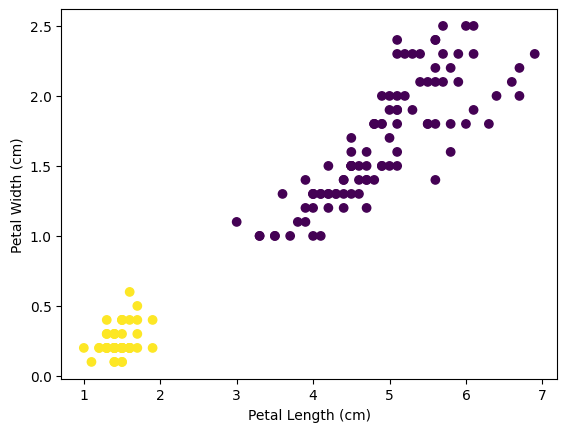

In [12]:
setosa = iris['target'] == 0

fig = plt.figure()
plt.scatter(iris['data'][:,2], iris['data'][:,3], c=setosa)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.show()

In [11]:
import numpy as np
from Code import SVCdemo as demo
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

def run_demo(num_iters=10):
    # Load iris dataset
    iris = load_iris()
    X = iris.data[:, 2:4]  # petal length and petal width
    y = iris.target

    # Create binary classification: setosa (0) vs others (1, 2)
    y_binary = (y != 0).astype(int)
    y_binary = 2 * y_binary - 1  # Convert to -1, 1 for SVM

    # Extract features
    petal_length = X[:, 0]
    petal_width = X[:, 1]

    # Separate classes for plotting
    setosa_mask = y_binary == -1
    other_mask = y_binary == 1

    print("=" * 60)
    print("Support Vector Classifier - Margin Expansion Demonstration")
    print("=" * 60)
    print()

    # Step 1: Start with a simple vertical line at petal_length ≈ 3
    print("Step 1: Starting with initial boundary (vertical line at petal_length ≈ 3)")
    w_init = np.array([6.0, 0.0])  # Vertical line
    b_init = -3.0  # Around x1 = 3

    margin_init, valid_init = demo.compute_margin(w_init, b_init, X, y_binary)
    if valid_init:
        print(f"  Initial margin: {margin_init:.4f}")
    else:
        print("  Initial boundary doesn't separate classes correctly")

    # Step 2: Iteratively expand margin
    print("\nStep 2: Expanding margin iteratively...")
    print("  (Searching for optimal hyperplane)")

    # Try different orientations and positions
    best_margin = 0
    best_w = w_init
    best_b = b_init

    # Grid search over different hyperplane orientations
    angles = np.linspace(-np.pi/2, np.pi/2, 50)
    offsets = np.linspace(-5, 5, 50)

    iteration = 0
    for angle in angles:
        w_test = np.array([np.cos(angle), np.sin(angle)])
        
        for offset in offsets:
            b_test = offset
            margin, valid = demo.compute_margin(w_test, b_test, X, y_binary)
            
            if valid and margin > best_margin:
                best_margin = margin
                best_w = w_test
                best_b = b_test
                iteration += 1
                
                if iteration % 50 == 0:
                    print(f"  Iteration {iteration}: margin = {best_margin:.4f}")

    print(f"\nStep 3: Optimal margin found: {best_margin:.4f}")
    print(f"  Decision boundary: {best_w[0]:.4f}*x1 + {best_w[1]:.4f}*x2 + {best_b:.4f} = 0")

    # Step 4: Refine with gradient descent
    print("\nStep 4: Refining with gradient descent optimization...")
    w_final, b_final = demo.train_svm(X, y_binary, learning_rate=0.001, epochs=num_iters, C=10.0)

    # Normalize w so that margin constraints are w·x + b = ±1
    # Find support vectors (points closest to the boundary)
    distances = y_binary * (X @ w_final + b_final)
    support_vector_idx = np.argmin(np.abs(distances - 1))
    scaling_factor = 1.0 / distances[support_vector_idx]
    w_final *= scaling_factor
    b_final *= scaling_factor

    margin_final, _ = demo.compute_margin(w_final, b_final, X, y_binary)
    print(f"  Final margin: {margin_final:.4f}")
    print(f"  Final decision boundary: {w_final[0]:.4f}*x1 + {w_final[1]:.4f}*x2 + {b_final:.4f} = 0")

    # Identify support vectors
    margins = y_binary * (X @ w_final + b_final)
    support_vectors = np.abs(margins - 1) < 0.1
    print(f"\nNumber of support vectors: {np.sum(support_vectors)}")

    # Plot final result
    plt.figure(figsize=(12, 6))

    # Plot points
    setosa_mask = y_binary == -1
    other_mask = y_binary == 1

    plt.scatter(X[setosa_mask, 0], X[setosa_mask, 1], 
                c='blue', marker='o', s=100, label='Setosa', edgecolors='k', alpha=0.7)
    plt.scatter(X[other_mask, 0], X[other_mask, 1], 
                c='red', marker='s', s=100, label='Others (Versicolor & Virginica)', 
                edgecolors='k', alpha=0.7)

    # Highlight support vectors
    plt.scatter(X[support_vectors, 0], X[support_vectors, 1], 
                s=300, facecolors='none', edgecolors='green', linewidths=3,
                label='Support Vectors')

    # Create grid for decision boundary
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

    # Plot decision boundary: w1*x1 + w2*x2 + b = 0
    x1_line = np.array([x1_min, x1_max])
    x2_line = -(w_final[0] * x1_line + b_final) / w_final[1]
    plt.plot(x1_line, x2_line, 'k-', linewidth=2.5, label='Decision Boundary')

    # Plot margins: w1*x1 + w2*x2 + b = ±1
    x2_margin_plus = -(w_final[0] * x1_line + b_final - 1) / w_final[1]
    x2_margin_minus = -(w_final[0] * x1_line + b_final + 1) / w_final[1]
    plt.plot(x1_line, x2_margin_plus, 'k--', linewidth=2, label='Margin Boundaries')
    plt.plot(x1_line, x2_margin_minus, 'k--', linewidth=2)

    plt.xlabel('Petal Length (cm)', fontsize=13, fontweight='bold')
    plt.ylabel('Petal Width (cm)', fontsize=13, fontweight='bold')
    plt.title(f'Maximal Margin Classifier (SVM)\nMargin Width: {margin_final:.4f} cm', 
            fontsize=15, fontweight='bold')
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)

    plt.tight_layout()
    # plt.savefig('/mnt/user-data/outputs/svc_maximal_margin.png', dpi=300, bbox_inches='tight')
    plt.show()

    # print("\n" + "=" * 60)
    # print("Visualization saved!")
    # print("=" * 60)

Support Vector Classifier - Margin Expansion Demonstration

Step 1: Starting with initial boundary (vertical line at petal_length ≈ 3)
  Initial boundary doesn't separate classes correctly

Step 2: Expanding margin iteratively...
  (Searching for optimal hyperplane)

Step 3: Optimal margin found: 0.6375
  Decision boundary: 0.9144*x1 + 0.4048*x2 + -2.5510 = 0

Step 4: Refining with gradient descent optimization...
  Final margin: -1.0000
  Final decision boundary: 1.7832*x1 + 1.8483*x2 + -3.1528 = 0

Number of support vectors: 2


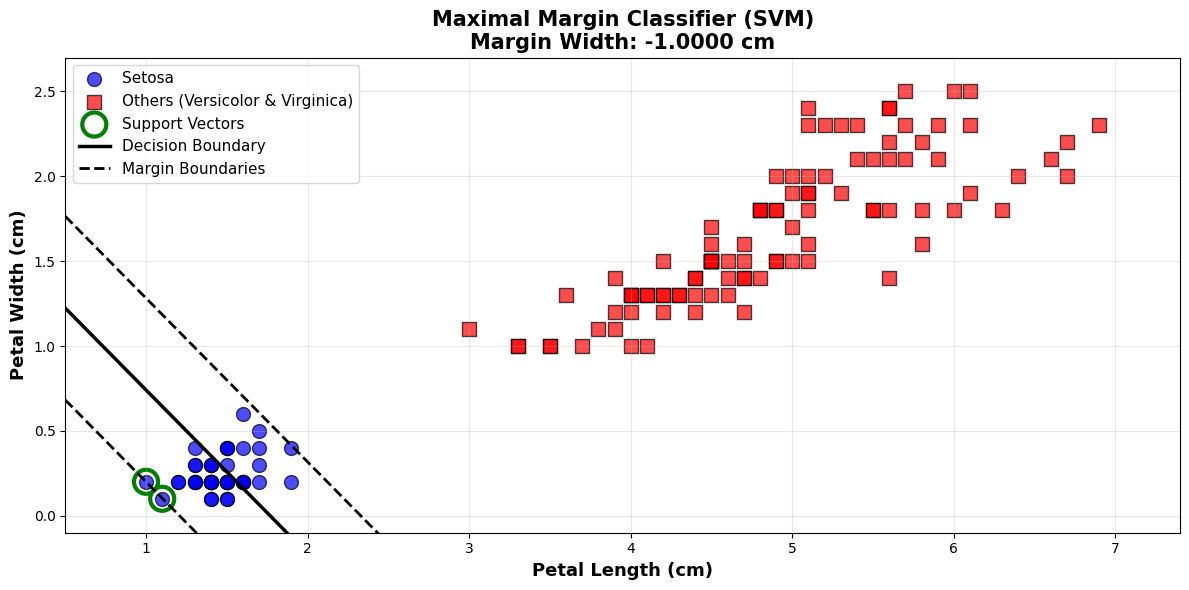

In [16]:
run_demo(num_iters=13)

Text(0, 0.5, 'Petal Width (cm)')

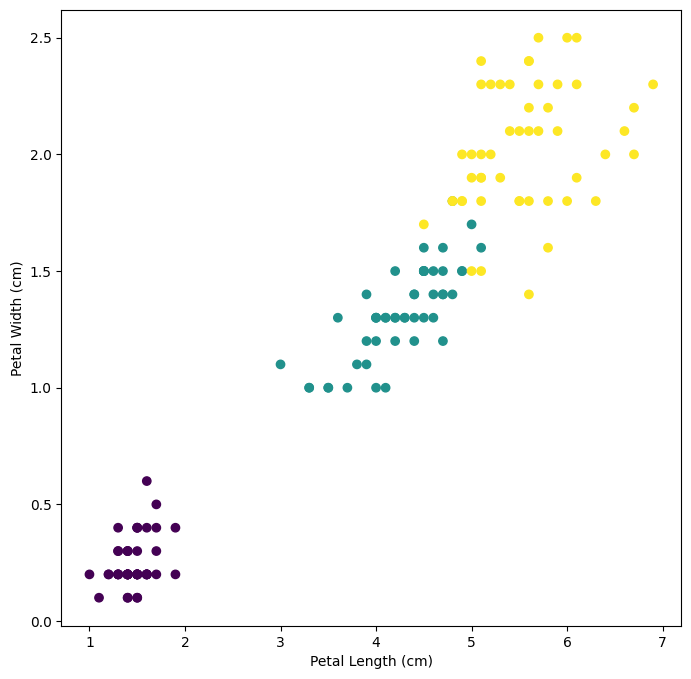

In [ ]:
fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot()
ax.scatter(#iris['data'][50:,0],
           iris['data'][50:,2],
           iris['data'][50:,3],
           c=iris['target'][:100])
          
ax.set_xlabel('Petal Length (cm)')
ax.set_ylabel('Petal Width (cm)')

## Preprocessing
1. Missing Data - No missing values in this example
2. Encode Categorical Variables - Using original data, no categorical variables
3. Split the data
4. Feature Scaling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [ ]:
list(iris)

In [ ]:
iris['feature_names']

In [ ]:
X = iris['data'][:,(2,3)]
y = (iris['target'] == 2).astype(np.float64)

## SVC model

In [ ]:
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

Description of hyperparameters:
* `C` is the regularization parameter - determines the number of misclassifications
  * High C means we regularize more (allow fewer misclassifications) - smaller margins
  * Low C means we regularize less (allow more misclassifications) - larger margins
* `loss` is the loss function
  * None selected by default - we have to set one to run the model
  * `hinge` is the typical loss type

## Evaluate the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))